In [1]:
import tensorflow as tf
import keras
from keras import layers
from keras.preprocessing import image
import numpy as np
import csv
import matplotlib.pyplot as plt

print(tf.__version__)
print(tf.test.is_gpu_available())

Using TensorFlow backend.


1.13.1
True


In [2]:
#reading driving log into a list, data format is [center_img_dir, left_img_dir, right_img_dir, steering angle, throttle, break , speed]
driving_logs = []
with open('./sim_data/20190725/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        driving_logs.append(row)

In [3]:
#seperate the left images, right images, center images, and add the last four output as a regression targets
center_images = []
left_images = []
right_images = []
ctr_targets = []
for data in driving_logs:
    center_img = np.array(image.load_img(data[0], target_size=(32, 32)))
    center_images.append(center_img)
    left_img = np.array(image.load_img(data[1], target_size=(32, 32)))
    left_images.append(left_img)
    right_img = np.array(image.load_img(data[2], target_size=(32, 32)))
    right_images.append(right_img)
    ctr = []
    for n in data[3:]:
        ctr.append(n)
    ctr_targets.append(np.array(ctr))
    
center_images = np.array(center_images)/255.0
left_images = np.array(left_images)/255.0
right_images = np.array(right_images)/255.0
ctr_targets = np.array(ctr_targets)

In [4]:
print(center_images.shape)

(2979, 32, 32, 3)


In [5]:
def cnn_model(Input):
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(Input)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(10, activation='relu')(x)
    return x 

In [6]:
center_input = layers.Input(shape=(32,32,3))
left_input = layers.Input(shape=(32,32,3))
right_input = layers.Input(shape=(32,32,3))

In [7]:
center_output = cnn_model(center_input)
center_model = keras.Model(inputs=center_input,  outputs=center_output)

left_output = cnn_model(left_input)
left_model = keras.Model(inputs=left_input,  outputs=left_output)

right_output = cnn_model(right_input)
right_model = keras.Model(inputs=right_input,  outputs=right_output)

combined = layers.concatenate([center_model.output, left_model.output, right_model.output])

combined_output = layers.Dense(64, activation='relu')(combined)
combined_output = layers.Dense(4, activation='relu')(combined_output)
combined_model = keras.Model(inputs=[center_model.input, left_model.input, right_model.input], outputs=combined_output)

Instructions for updating:
Colocations handled automatically by placer.


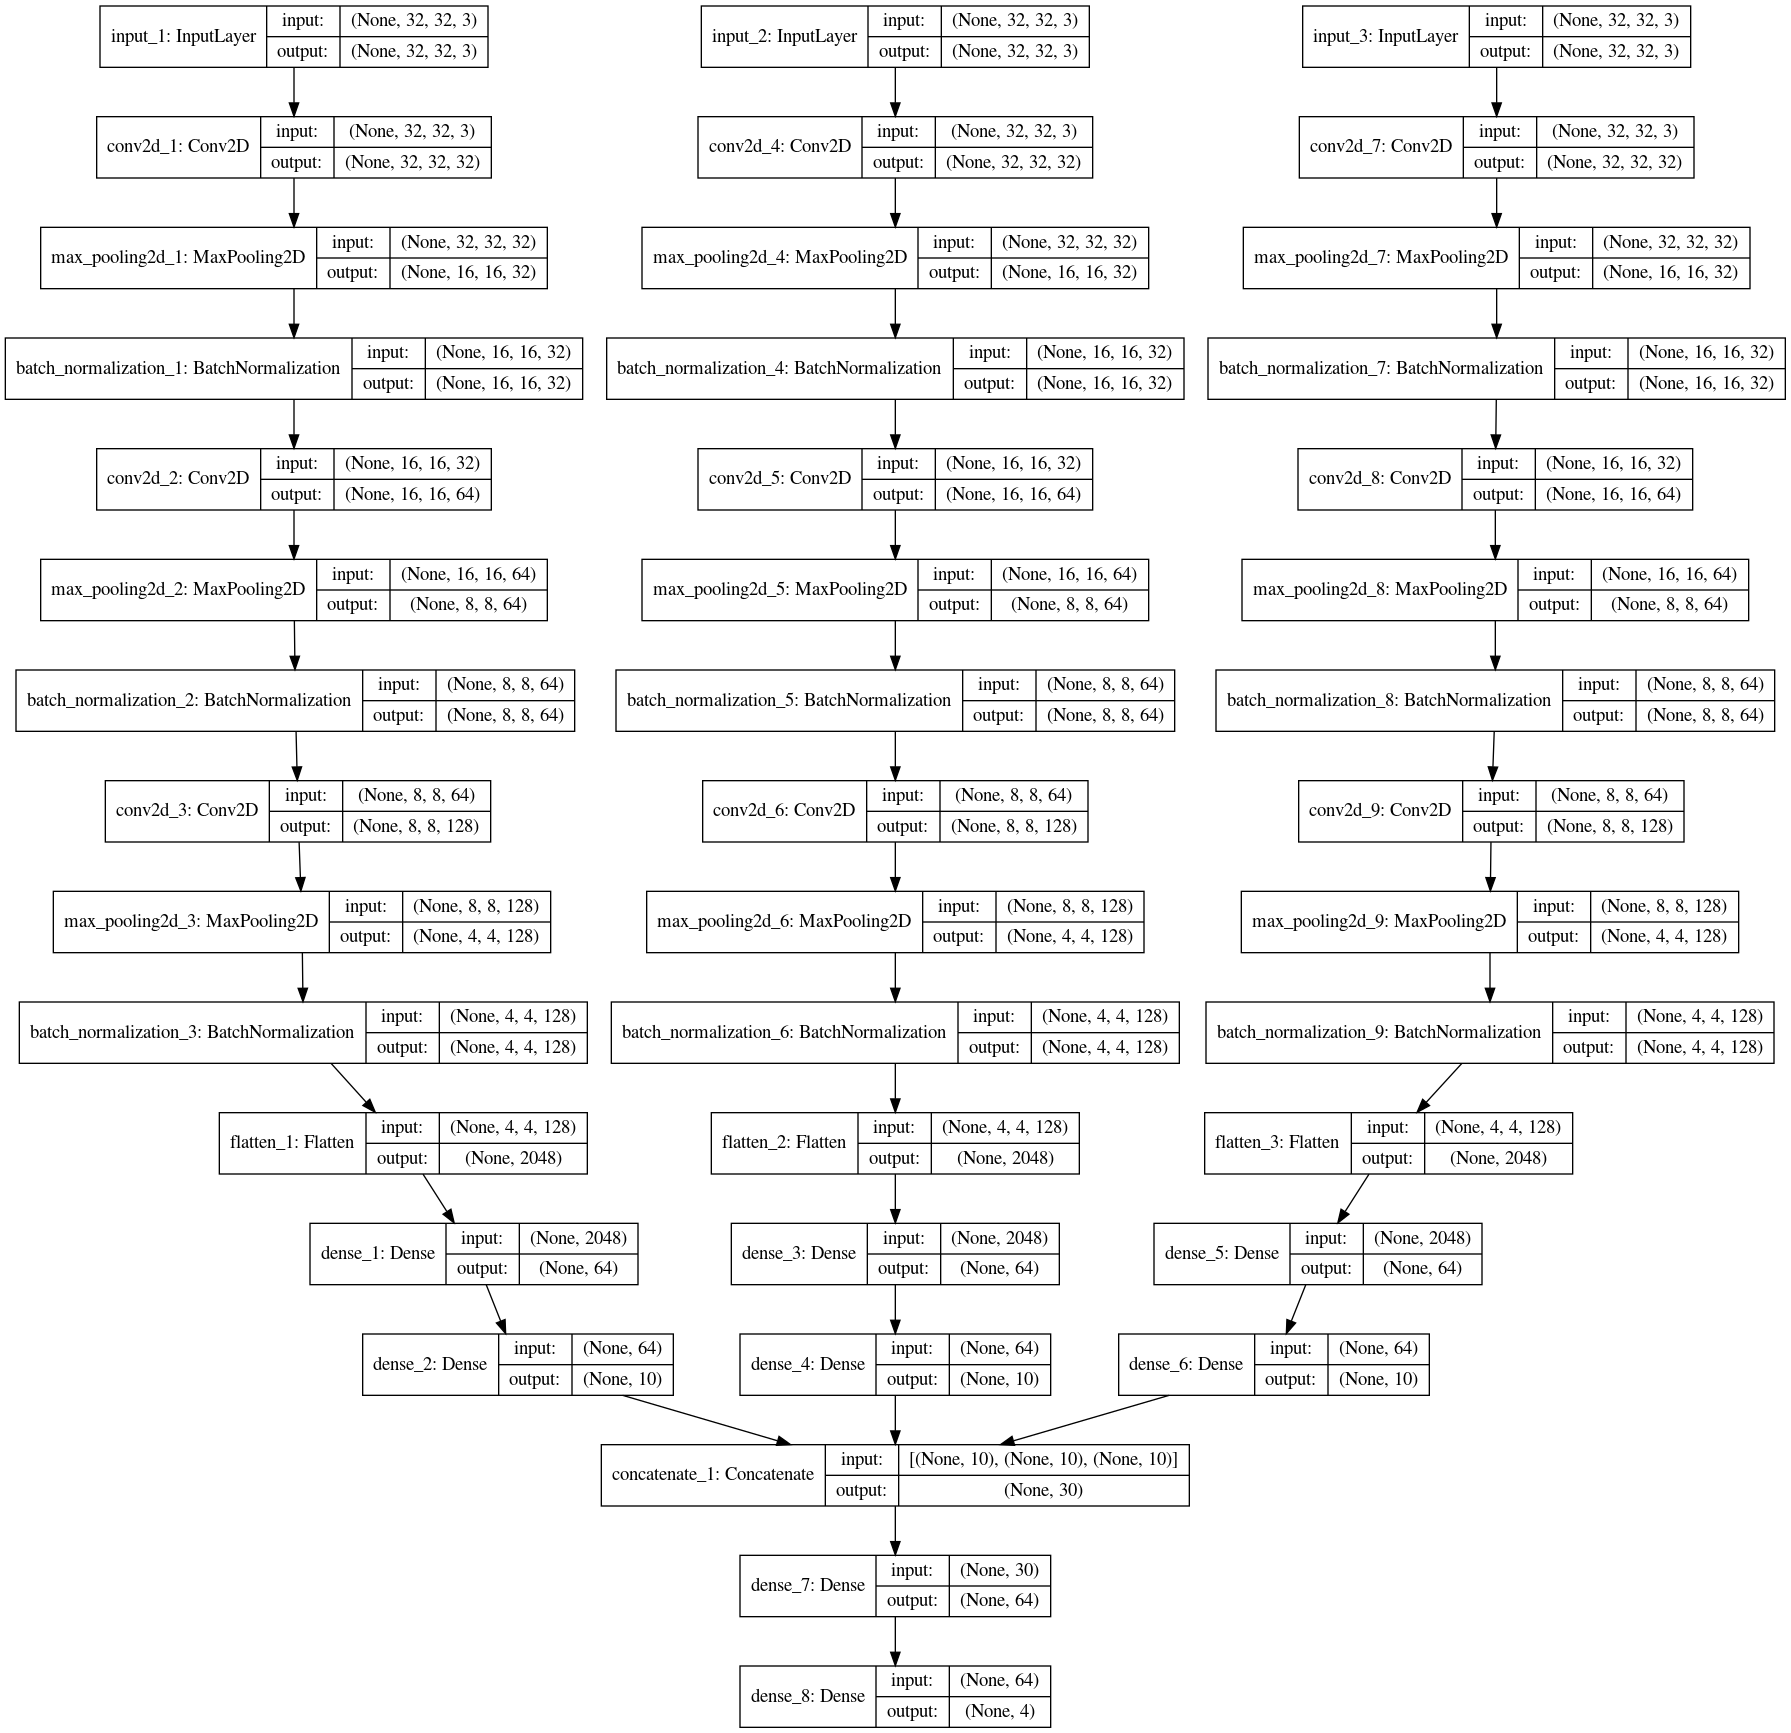

In [8]:
import matplotlib.pyplot as plt
from IPython.display import Image
from tensorflow.keras.utils import plot_model

plot_model(combined_model, to_file='combined_model.png', show_shapes=True)

Image(retina=True, filename='combined_model.png')

In [9]:
combined_model.compile(optimizer='adam',
                      loss = 'mse',
                      metrics=['mse'])

In [10]:
history = combined_model.fit([center_images, left_images, right_images], ctr_targets, 
                            batch_size=256,
                             epochs=10,
                            validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 2383 samples, validate on 596 samples
Epoch 1/10
2383/2383 [==============================] - 12s 5ms/step - loss: 69.2252 - mean_squared_error: 69.2252 - val_loss: 6.4357 - val_mean_squared_error: 6.4357
Epoch 2/10
2383/2383 [==============================] - 1s 239us/step - loss: 5.2946 - mean_squared_error: 5.2946 - val_loss: 8.8489 - val_mean_squared_error: 8.8489
Epoch 3/10
2383/2383 [==============================] - 1s 234us/step - loss: 2.3527 - mean_squared_error: 2.3527 - val_loss: 8.0491 - val_mean_squared_error: 8.0491
Epoch 4/10
2383/2383 [==============================] - 1s 228us/step - loss: 1.4593 - mean_squared_error: 1.4593 - val_loss: 3.4843 - val_mean_squared_error: 3.4843
Epoch 5/10
2383/2383 [==============================] - 1s 238us/step - loss: 0.9311 - mean_squared_error: 0.9311 - val_loss: 2.1907 - val_mean_squared_error: 2.1907
Epoch 6/10
2383/2383 [==============================] - 1s 229us/step - lo

In [11]:
combined_model.save('./3H_CNN_model.h5')